In [3]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [4]:
FAST_RUN = False
IMAGE_WIDTH=275
IMAGE_HEIGHT=267
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3  # set to 1

In [5]:
# filter noised pictures
df_defect_filtered = pd.read_csv('data/defect_area.csv')
df_defect = pd.DataFrame({
    'id': df_defect_filtered['id'],
    'defect_score': 1
})

for i in range(len(df_defect)):
    df_defect.loc[i,'id'] = 'defect/'+ df_defect.loc[i,'id']+ '.bmp'

# df_defect.head()
# df_defect.tail()

In [6]:
filenames = os.listdir("data/train/train_contest/good_all")

df_good_all = pd.DataFrame({
    'id': filenames,
    'defect_score': 0
})

for i in range(len(filenames)):
    df_good_all.loc[i,'id'] = 'good_all/'+ df_good_all.loc[i,'id']
    
# df_good_all.head()
# df_good_all.tail()

In [7]:
# df_train_all = pd.concat([df_defect, df_good_all])
df_train_all = pd.concat([df_good_all, df_defect])

# model

In [8]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding="same", activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have defect and good classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 275, 267, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 275, 267, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 137, 133, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 137, 133, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 137, 133, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 137, 133, 32)      128       
____

In [9]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

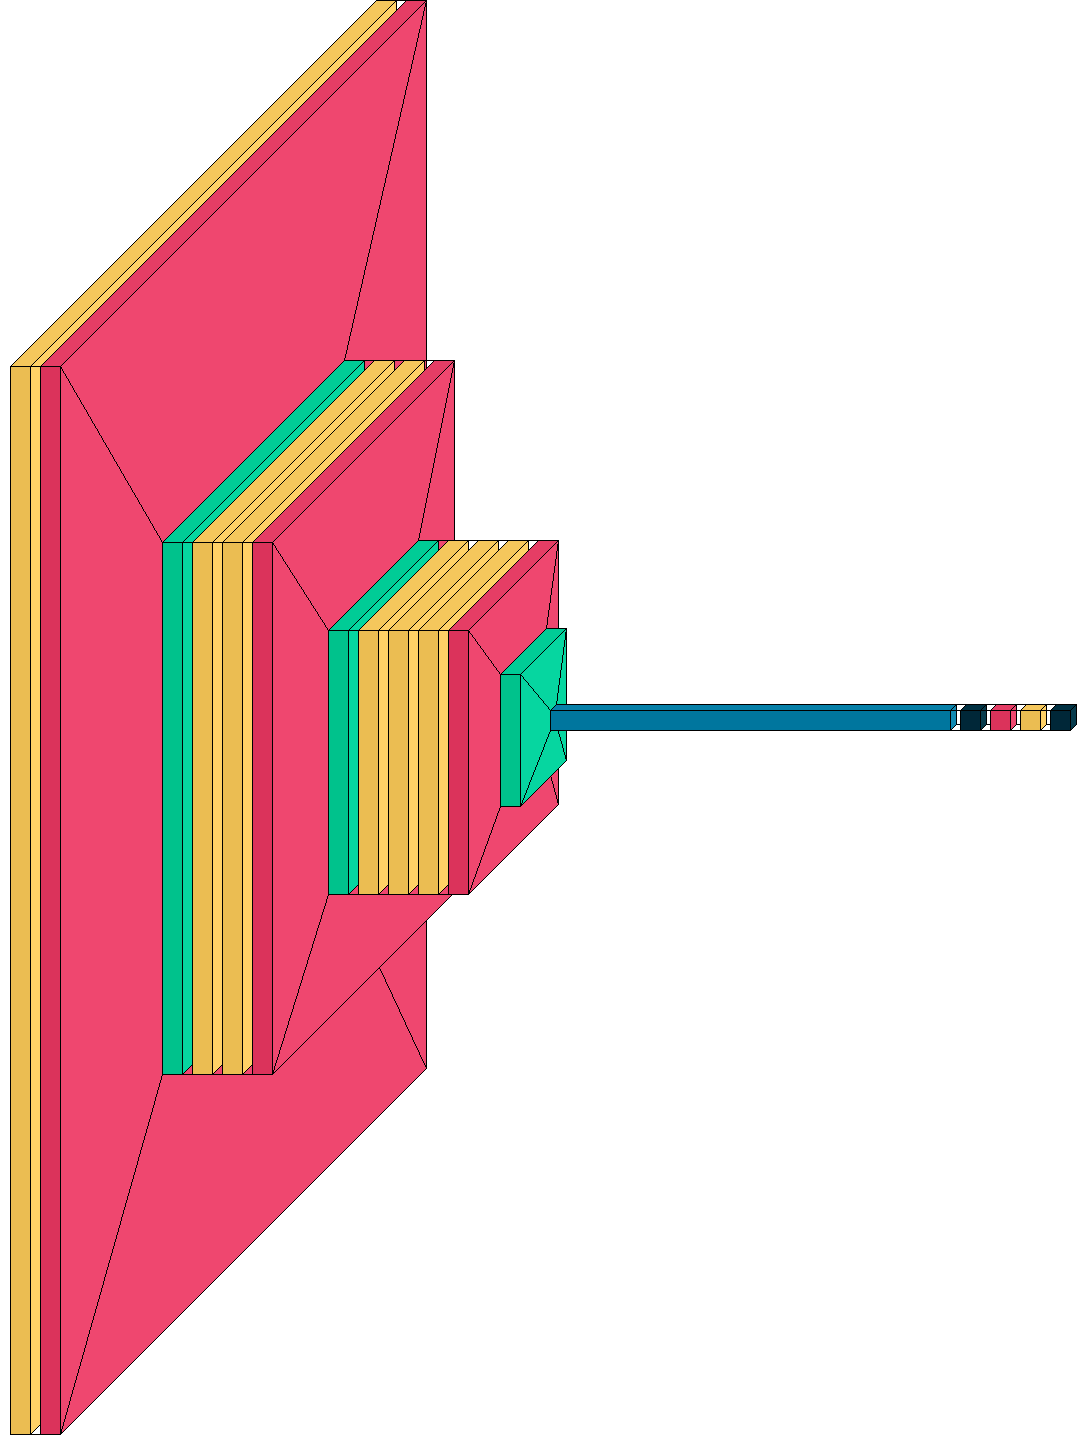

In [30]:
import visualkeras
visualkeras.layered_view(model)

# Training data

In [10]:
df_train_all["defect_score"] = df_train_all["defect_score"].replace({0: 'good_all', 1: 'defect'}) 

In [11]:
df_train, df_validate = train_test_split(df_train_all, test_size=0.10, random_state=42)

df_train = df_train.reset_index(drop=True)
df_validate = df_validate.reset_index(drop=True)

In [12]:
df_train.shape, df_validate.shape

((30704, 2), (3412, 2))

<AxesSubplot:>

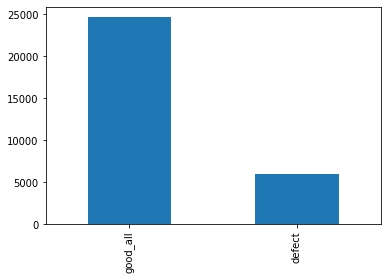

In [13]:
df_train['defect_score'].value_counts().plot.bar()

<AxesSubplot:>

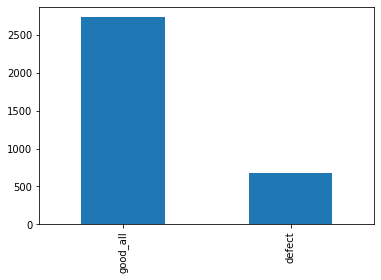

In [14]:
df_validate['defect_score'].value_counts().plot.bar()

In [15]:
total_train = df_train.shape[0]
total_validate = df_validate.shape[0]
batch_size=100

# Traning Generator

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=0,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df_train, 
    "data/train/train_contest", 
    x_col='id',
    y_col='defect_score',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 30704 validated image filenames belonging to 2 classes.


In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    df_validate, 
    "data/train/train_contest", 
    x_col='id',
    y_col='defect_score',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 3412 validated image filenames belonging to 2 classes.


In [18]:
# df_example = df_train.sample(n=1).reset_index(drop=True)

# example_generator = train_datagen.flow_from_dataframe(
#     df_example, 
#     "data/train/train_contest", 
#     x_col='id',
#     y_col='defect_score',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical'
# )

In [19]:
# plt.figure(figsize=(12, 12))

# for i in range(0, 15):
#     plt.subplot(5, 3, i+1)
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

# Fit Model

In [19]:
# epochs=3 if FAST_RUN else 50
epochs=20

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
307/307 [==============================] - 1266s 4s/step - loss: 0.5609 - acc: 0.7679 - val_loss: 0.7242 - val_acc: 0.8032
Epoch 2/20
307/307 [==============================] - 1272s 4s/step - loss: 0.3282 - acc: 0.8723 - val_loss: 0.3809 - val_acc: 0.8350
Epoch 3/20
307/307 [==============================] - 1267s 4s/step - loss: 0.2320 - acc: 0.9123 - val_loss: 0.3299 - val_acc: 0.8894
Epoch 4/20
307/307 [==============================] - 1272s 4s/step - loss: 0.1877 - acc: 0.9329 - val_loss: 0.8845 - val_acc: 0.8426
Epoch 5/20
306/307 [============================>.] - ETA: 4s - loss: 0.1600 - acc: 0.9428
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
307/307 [==============================] - 1271s 4s/step - loss: 0.1597 - acc: 0.9430 - val_loss: 0.3121 - val_acc: 0.8809
Epoch 6/20
307/307 [==============================] - 1272s 4s/step - loss: 0.1243 - acc: 0.9572 - val_loss: 0.1993 - val_acc: 0.9224
Epoch 7/20
307/307 [================

In [20]:
model.save_weights("model_20_eps_pure_final.h5")

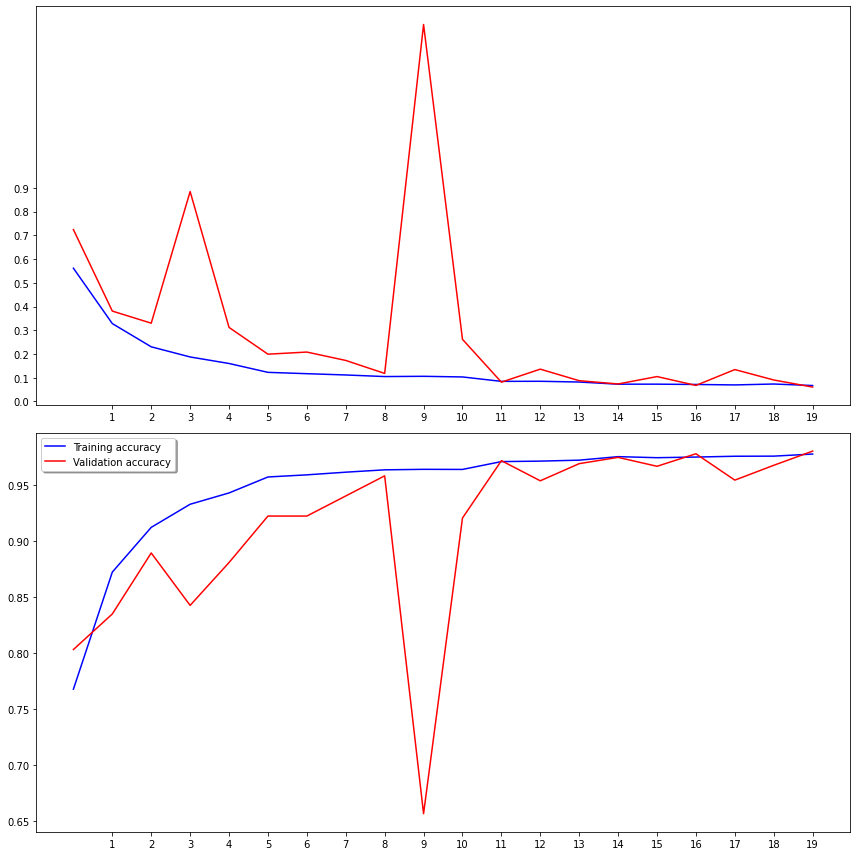

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [20]:
model.load_weights("model_20_eps_pure_final.h5")

In [21]:
Y_pred = model.predict_generator(validation_generator, total_validate//batch_size+1 )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 633   42]
 [  25 2712]]


In [75]:
pd.DataFrame(Y_pred).to_csv('Y_pred.csv')

array([[1.3066614e-07, 9.9999988e-01],
       [4.4972211e-08, 1.0000000e+00],
       [3.8436302e-03, 9.9615639e-01],
       ...,
       [5.6884210e-06, 9.9999428e-01],
       [2.1591571e-08, 1.0000000e+00],
       [3.3390499e-04, 9.9966609e-01]], dtype=float32)

In [ ]:
gt=np.array(validation_generator.classes)
gt

In [26]:
pd.DataFrame(y_pred).to_csv('cnn_pred.csv')

In [27]:
pd.DataFrame(df_validate).to_csv('cnn_gt.csv')

In [24]:
df_validate[0:20]

,id,defect_score
0,good_all/WEE93900160A_06-1FW-ITISA45-2_335_3.bmp,good_all
1,good_all/WEL927267D5A_19-WCM-ITISA53-1_21_3.bmp,good_all
2,defect/WEP93139451A_01-APG_ITIS_H45_2_361_1.bmp,defect
3,good_all/WEP93617352A_40-1GW-ITISA49-1_225_2.bmp,good_all
4,good_all/WEP93714351A_04-TVW-ITISA43-2_950_2.bmp,good_all
5,good_all/WEP93714111A_02-TXW-ITISA45-1_235_2.bmp,good_all
6,good_all/WEP93731391A_16-5BW-ITISA45-2_13_1.bmp,good_all
7,good_all/WEP93724194A_20-5CW-ITISA47-2_16_2.bmp,good_all
8,good_all/WEP937059A1A_27-210-ITISA57-2_112_2.bmp,good_all
9,good_all/WEL93019915A_01-WS4-ITISA09-1_198_2.bmp,good_all


In [25]:
validation_generator.classes[0:20]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]

In [23]:
print('Classification Report')
target_names = ['Defect', 'Good']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Defect       0.96      0.94      0.95       675
        Good       0.98      0.99      0.99      2737

    accuracy                           0.98      3412
   macro avg       0.97      0.96      0.97      3412
weighted avg       0.98      0.98      0.98      3412



In [28]:
def display_heatmap(new_model, img_path, ids, preprocessing=None):
    # The quality is reduced.
    # If you have more than 8GB of RAM, you can try to increase it.
    img = image.load_img(img_path, target_size=(800, 1280))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if preprocessing is not None:
        x = preprocess_input(x)

    out = new_model.predict(x)

    heatmap = out[0]  # Removing batch axis.

    if K.image_data_format() == 'channels_first':
        heatmap = heatmap[ids]
        if heatmap.ndim == 3:
            heatmap = np.sum(heatmap, axis=0)
    else:
        heatmap = heatmap[:, :, ids]
        if heatmap.ndim == 3:
            heatmap = np.sum(heatmap, axis=2)

    plt.imshow(heatmap, interpolation="none")
    plt.show()

In [ ]:
new_model = to_heatmap(model)

s = "n02084071"  # Imagenet code for "dog"
ids = synset_to_dfs_ids(s)
display_heatmap(new_model, "./dog.jpg", ids, preprocess_input)

# Prepare Testing Data

In [24]:
test_filenames = os.listdir("data/test/test_contest/test")

test_df = pd.DataFrame({
    'id': test_filenames
})

nb_samples = test_df.shape[0]

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/test/test_contest/test", 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 3830 validated image filenames.


# Predict

In [26]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [27]:
test_df['defect_score'] = predict[:,0]

# Submission

In [28]:
# from PIL import Image

# for i in range(len(test_df['defect_score'])):
#     origin_image = Image.open( 'data/test/test_contest/test/' + test_df['id'][i])
#     if(origin_image.size!=(275, 267)):
#         print(origin_image.size)
#         test_df['defect_score'][i]=1

In [29]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['id'].str.split('.').str[0]
submission_df.to_csv('final_20_epoch_pure.csv', index=False)